In [1]:
import numpy as np
import keras
from keras.datasets import fashion_mnist
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [2]:
def sigmoid(a):
    s = 1/(1+np.exp(-a))
    return s

def derivative_sigmoid(a):
    ds = sigmoid(a) *(1-sigmoid (a))
    return ds

def tanh(a):
    t=(np.exp(a)-np.exp(-a))/(np.exp(a)+np.exp(-a))
    return t

def derivative_tanh(a):
    dt=1-tanh(a)**2
    return dt


def softmax(a):
    return np.exp(a) / np.sum(np.exp(a), axis=0) #expA (axis=0, keepdims=True)

In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [4]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_orig, y_train_orig), (x_test_orig, y_test_orig) = fashion_mnist.load_data()

In [5]:
def initialize_parameters(layer_dimensions):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    #np.random.seed(0)
    parameters = {}
    L = len(layer_dimensions)            # number of layers in the network

    for k in range(1, L):
        
        parameters['w' + str(k)] = np.random.randn(layer_dimensions[k], layer_dimensions[k-1]) 
        parameters['b' + str(k)] = np.zeros((layer_dimensions[k], 1))
        
#         assert(parameters['w' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
#         assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))    
    return parameters

In [6]:
def linear_agrregation(h, w, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    h -- activations from previous layer (or input data): (size of previous layer, number of examples)
    w -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    a -- the input of the activation function, also called pre-activation parameter 
    temp -- a python tuple containing "h", "w" and "b" ; stored for computing the backward pass efficiently
    """
    
    a = np.dot(w, h) + b

    #assert(Z.shape == (W.shape[0], A.shape[1]))
    temp = (h,w,b)
    
    return a ,temp

In [7]:
def activation(h_prev, w, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    h_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    w -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    h -- the output of the activation function, also called the post-activation value 
    cache -- a python tuple containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
    
    if activation == "sigmoid":

        a, linear_temp = linear_agrregation(h_prev, w, b)
        h = sigmoid(a)
    
    elif activation == "tanh":
        a, linear_temp = linear_agrregation(h_prev, w, b)
        h = tanh(a)
        
    elif activation == "softmax":
        a, linear_temp = linear_agrregation(h_prev, w, b)
        h = softmax(a)
    
    
#     assert (A.shape == (W.shape[0], A_prev.shape[1]))
    temp = (linear_temp, a)

    return h, temp

In [8]:
def forward_pass(x, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_activation_forward() (there are L-1 of them, indexed from 0 to L-1)
    """

    temps = []
    h = x
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for k in range(L-1):
        l = k+1
        h_prev = h 
        h,temp = activation(h_prev, parameters['w'+str(l)], parameters['b'+str(l)], activation="sigmoid")
        temps.append(temp)
    
    
    hL,temp1 = activation(h, parameters['w'+str(L)], parameters['b'+str(L)], activation="softmax")
    temps.append(temp1)
    
    #assert(AL.shape == (1,X.shape[1]))
            
    return hL, temps

In [9]:
def cost_function(yhat, y):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    hL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    m = y.shape[1] # no. of examples
  

    # Compute loss from aL and y.
    product_sum = np.sum((y *np.log(yhat)), axis = 0)
    cost = -1/m*np.sum(product_sum)
    
    ### END CODE HERE ###
    
    #cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    #assert(cost.shape == ())
    
    return cost

In [10]:
def linear_backward(dL_da, temp):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    h_prev, w, b = temp
    m = h_prev.shape[1]

    dL_dh_prev = np.dot(w.T, dL_da)
    
    dL_dw = 1/m*np.dot(dL_da, h_prev.T)
    dL_db = 1/m*np.sum(dL_da, axis=1, keepdims=True)
     
    
#     assert (dA_prev.shape == A_prev.shape)
#     assert (dW.shape == W.shape)
#     assert (db.shape == b.shape)
    
    return dL_dh_prev, dL_dw, dL_db

In [11]:
def linear_activation_backward(dL_dh, temp, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dL_dh -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dL_dh_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_temp, a = temp
    
    if activation == "sigmoid":
        ds = derivative_sigmoid(a)
        dL_da = dL_dh * ds
       
        dL_dh_prev, dL_dw, dL_db = linear_backward(dL_da, linear_temp)    
        
    elif activation == "tanh":
        dt = derivative_tanh(a)
        dL_da = dL_dh * dt

        dL_dh_prev, dL_dw, dL_db = linear_backward(dL_da, linear_temp)    
    
    return dL_dh_prev, dL_dw, dL_db

In [12]:
def backward_pass(yhat, y, temps):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (it's caches[l],
                for l in range(L-1) i.e l = 0...L-2)
                the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(temps) # the number of layers
    m = y.shape[1]
#     Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
#     dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL)) # derivative of cost with respect to AL

# el = one hot vector
    el = y
    dL_dyhat = -(1/yhat)*el
    dL_daL  = -(el - yhat)
    current_temp = temps[L-1]
    linear_tempL,aL = current_temp
    
    hL_prev, wL, bL = linear_tempL
    m = hL_prev.shape[1]

    dL_dhL_prev = np.dot(wL.T, dL_daL)
    
    dL_dwL = 1/m*np.dot(dL_daL, hL_prev.T)
    dL_dbL = 1/m*np.sum(dL_daL, axis=1, keepdims=True)

    
    grads["dL_dh" + str(L-1)] = dL_dhL_prev
    grads["dL_dw" + str(L)]      = dL_dwL
    grads["dL_db" + str(L)] = dL_dbL
    
    # Loop from l=L-2 to l=0
    for l in reversed(range(L-1)):
        #print(l)
        current_temp = temps[l]
        dL_dh_prev, dL_dw, dL_db = linear_activation_backward(grads["dL_dh" + str(l+1)], current_temp, "sigmoid")
        grads["dL_dh" + str(l)] = dL_dh_prev
        grads["dL_dw" + str(l + 1)] = dL_dw
        grads["dL_db" + str(l + 1)] = dL_db
        #print(grads)
        ### END CODE HERE ###

    return grads

In [13]:
def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    
    L = len(parameters) // 2 # number of layers in the neural network

    for l in range(L):
        parameters["w" + str(l+1)] = parameters["w" + str(l+1)]-learning_rate*grads["dL_dw" + str(l + 1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)]-learning_rate*grads["dL_db" + str(l + 1)]

    return parameters

In [14]:
x_train_orig = x_train_orig[:1000]
x_test_orig = x_test_orig[:50]
y_train_orig = y_train_orig[:1000]
y_test_orig = y_train_orig[:50]
y_train_orig.shape

(1000,)

In [15]:
x_train_flatten = x_train_orig.reshape(x_train_orig.shape[0], -1).T
x_test_flatten = x_test_orig.reshape(x_test_orig.shape[0], -1).T
x_train = x_train_flatten/255
x_test = x_test_flatten/255

print ("x_train's shape: " + str(x_train.shape))
print ("x_test's shape: " + str(x_test.shape))


x_train's shape: (784, 1000)
x_test's shape: (784, 50)


y = 9. It's a Ankle boot picture.


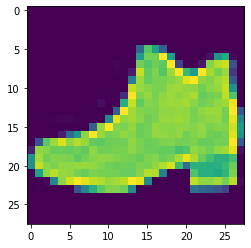

In [16]:
index = 15
plt.imshow(x_train_orig[index])
print ("y = " + str(y_train_orig[index])+ ". It's a " + class_names[y_train_orig[index]] +  " picture.")

In [17]:
no_hidden_layers = 3 # no of hidden layers
no_neuron_hidden = 784 # no. of neurons in each hidden layers
no_neuron_output = 10 # # no. of neurons in each hidden layers

In [18]:
no_of_training_examples = np.shape(x_train)[1]
no_of_testing_examples = np.shape(x_test)[1]
size_input_layer = np.shape(x_train)[0]
size_hidden_layer = no_neuron_hidden
size_output_layer = no_neuron_output

In [19]:
y_train_orig.shape[0]

1000

In [20]:
def one_hot_vector_form(labels,size_output_layer):
    no_of_examples = labels.shape[0]
    one_hot_vector = np.zeros((no_of_examples , size_output_layer))
    for i in range(no_of_examples):
        one_hot_vector[i, labels[i]] = 1    
        y = one_hot_vector.T
    return y
    

In [21]:
y_train = one_hot_vector_form(y_train_orig,size_output_layer)
y_test = one_hot_vector_form(y_test_orig,size_output_layer)
y_test.shape

(10, 50)

In [22]:
layer_dimensions = [size_input_layer]+ [size_hidden_layer]*no_hidden_layers+ [size_output_layer]
layer_dimensions

[784, 784, 784, 784, 10]

In [25]:
def L_layer_model(x, y, layer_dimensions, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):#lr was 0.009
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
   
    parameters = initialize_parameters(layer_dimensions)
 
    for i in range(0, num_iterations):

       
        yhat, temps = forward_pass(x, parameters)
 
        cost = cost_function(yhat, y)
        
        grads = backward_pass(yhat,y,temps)
        
        parameters = update_parameters(parameters, grads, learning_rate)
        
        #print("cost in iteration ",i," is =",cost)
                
        
            # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 25.970778
Cost after iteration 100: 3.301585
Cost after iteration 200: 1.541633
Cost after iteration 300: 0.792404
Cost after iteration 400: 0.437510
Cost after iteration 500: 0.261699
Cost after iteration 600: 0.165699
Cost after iteration 700: 0.111106
Cost after iteration 800: 0.078888
Cost after iteration 900: 0.058887


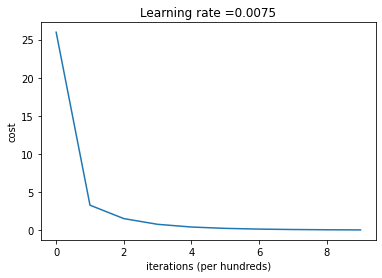

In [26]:
parameters = L_layer_model(x_train, y_train, layer_dimensions, num_iterations = 1000, print_cost = True)

In [86]:
def predict(x, y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = x.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # Forward propagation
    prob, temps = forward_pass(x, parameters)
    

    predicted_label = np.argmax(prob, axis=0)
    true_label = np.argmax(y, axis=0)
    
    Accuracy = np.sum(predicted_label == true_label)/1000
        
#         if probas[0,i] > 0.5:
#             p[0,i] = 1
#         else:
#             p[0,i] = 0
    
    #print results
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
    print("Accuracy: "  + str(Accuracy))
        
    return

In [87]:
predict(x_train,y_train,parameters)

Accuracy: 0.998


In [88]:
predict(x_test,y_test,parameters)

Accuracy: 0.006
